In [1]:
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

print(tf.__version__)


Segmentation Models: using `keras` framework.
2.12.0


In [ ]:
tf.keras.backend.clear_session()
tf.config.experimental.reset_memory_stats('GPU:0')

In [2]:
!# Define the color map
color_map = {
    0: [0, 0, 0],                # void
    1: [108, 64, 20],            # dirt
    2: [255, 229, 204],          # sand
    3: [0, 102, 0],              # grass
    4: [0, 255, 0],              # tree
    5: [0, 153, 153],            # pole
    6: [0, 128, 255],            # water
    7: [0, 0, 255],              # sky
    8: [255, 255, 0],            # vehicle
    9: [255, 0, 127],            # container/generic-object
    10: [64, 64, 64],            # asphalt
    11: [255, 128, 0],           # gravel
    12: [255, 0, 0],             # building
    13: [153, 76, 0],            # mulch
    14: [102, 102, 0],           # rock-bed
    15: [102, 0, 0],             # log
    16: [0, 255, 128],           # bicycle
    17: [204, 153, 255],         # person
    18: [102, 0, 204],           # fence
    19: [255, 153, 204],         # bush
    20: [0, 102, 102],           # sign
    21: [153, 204, 255],         # rock
    22: [102, 255, 255],         # bridge
    23: [101, 101, 11],          # concrete
    24: [114, 85, 47]            # picnic-table
}

# Create a reverse lookup to map colors to class labels
color_to_class = {tuple(value): key for key, value in color_map.items()}

def color_to_class_label(mask):
    # Convert mask to a 2D array where each pixel value is represented by an RGB tuple
    mask_rgb = mask.reshape(-1, 3)  # Reshape to a 2D array where each row is an RGB pixel

    # Map RGB values to class labels
    label_mask = np.array([color_to_class.get(tuple(rgb), 0) for rgb in mask_rgb])

    # Reshape back to the original mask shape (height, width)
    label_mask = label_mask.reshape(mask.shape[0], mask.shape[1])

    return label_mask

# def color_to_class_label(mask):
#     # Create an empty label mask
#     label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int32)  # Use np.int32 instead of np.long

#     # For each pixel, get the RGB value and map it to the class label
#     for i in range(mask.shape[0]):
#         for j in range(mask.shape[1]):
#             rgb_value = tuple(mask[i, j])
#             if rgb_value in color_to_class:
#                 label_mask[i, j] = color_to_class[rgb_value]
#             else:
#                 label_mask[i, j] = 0  # Default to class 0 if color is not found

#     return label_mask

In [3]:
# Paths
IMG_DIR = "./content/RUGD_frames"
MASK_DIR = "./content/RUGD_annotations"

IMG_SIZE = (224, 224)
NUM_CLASSES = 25  # Cityscapes has 19 semantic classes
BATCH_SIZE = 8  # Reduce batch size if kernel still crashes


# 🔹 **Get List of Files & Split Data**
def get_data_splits(test_size=0.1, val_size=0.1):
    img_files = []

    for root, _, files in os.walk(IMG_DIR):
        for file in files:
            if file.endswith('.png'):
                img_files.append(os.path.join(root, file))

    img_files.sort()  # Ensure consistency
    np.random.shuffle(img_files)  # Shuffle dataset

    # Split into train, validation, and test
    train_files, test_files = train_test_split(img_files, test_size=test_size, random_state=42)
    train_files, val_files = train_test_split(train_files, test_size=val_size / (1 - test_size), random_state=42)

    return train_files, val_files, test_files

# 🔹 **Function to Load Single Image**
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalize
    return img

# 🔹 **Function to Load Single Mask**
def load_mask(mask_path):
    mask = cv2.imread(mask_path)
    mask_resized = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)

    label_mask = color_to_class_label(mask_resized)

    return label_mask.astype(np.int32)  # Keep as integers (not one-hot)

# 🔹 **Dataset Generator**
def rugd_generator(file_list):
    for img_path in file_list:
        mask_path = os.path.join(MASK_DIR, os.path.relpath(img_path, IMG_DIR))


        # 🔹 Check if files exist before processing
        if not os.path.exists(mask_path):
            print(f"⚠️ Skipping - Mask file not found: {mask_path}")
            continue

        img = load_image(img_path)
        mask = load_mask(mask_path)

        yield img, mask


# 🔹 **Convert Generator to `tf.data.Dataset`**
def get_rugd_dataset(file_list, batch_size=BATCH_SIZE):
    dataset = tf.data.Dataset.from_generator(
        lambda: rugd_generator(file_list),
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(224, 224), dtype=tf.int32)
        )
    )

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)  # Optimize performance
    return dataset

# 🔹 **Create Train, Validation & Test Datasets**
train_files, val_files, test_files = get_data_splits()

print(f"Total images: {len(train_files) + len(val_files) + len(test_files)}")
print(f"Train set: {len(train_files)} images")
print(f"Validation set: {len(val_files)} images")
print(f"Test set: {len(test_files)} images")


train_dataset = get_rugd_dataset(train_files)
val_dataset = get_rugd_dataset(val_files)
test_dataset = get_rugd_dataset(test_files)


Total images: 7436
Train set: 5948 images
Validation set: 744 images
Test set: 744 images


In [4]:
from tensorflow.keras.metrics import MeanIoU

# Ensure compatibility with TensorFlow 2.x
sm.set_framework("tf.keras")

# Set Backbone to MobileNetV2
BACKBONE = "mobilenetv2"

# Load Pretrained U-Net (or PSPNet, FPN)
model = sm.Unet(BACKBONE,
                encoder_weights="imagenet",
                classes=25,
                activation="softmax",
                input_shape=(224, 224, 3)
               )

# Freeze ALL layers initially
for layer in model.layers:
    layer.trainable = False

# Unfreeze only the decoder and final conv layers
for layer in model.layers:
    if "decoder" in layer.name or "final_conv" in layer.name or "softmax" in layer.name:
        layer.trainable = True  # Fine-tune decoder

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", MeanIoU(num_classes=25, sparse_y_pred=False)])

model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1_pad (ZeroPadding2D)      (None, 225, 225, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['Conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

 ization)                                                                                         
                                                                                                  
 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malizatio

                                                                                                  
 block_6_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_6_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
          

 block_10_depthwise_BN (BatchNo  (None, 14, 14, 384)  1536       ['block_10_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_

 block_14_expand_relu (ReLU)    (None, 7, 7, 960)    0           ['block_14_expand_BN[0][0]']     
                                                                                                  
 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_

                                                                                                  
 decoder_stage0b_bn (BatchNorma  (None, 14, 14, 256)  1024       ['decoder_stage0b_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 decoder_stage0b_relu (Activati  (None, 14, 14, 256)  0          ['decoder_stage0b_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 decoder_stage1_upsampling (UpS  (None, 28, 28, 256)  0          ['decoder_stage0b_relu[0][0]']   
 ampling2D)                                                                                       
                                                                                                  
 decoder_s

                                                                                                  
 decoder_stage4a_bn (BatchNorma  (None, 224, 224, 16  64         ['decoder_stage4a_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 decoder_stage4a_relu (Activati  (None, 224, 224, 16  0          ['decoder_stage4a_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 decoder_stage4b_conv (Conv2D)  (None, 224, 224, 16  2304        ['decoder_stage4a_relu[0][0]']   
                                )                                                                 
                                                                                                  
 decoder_s

In [5]:
tf.config.run_functions_eagerly(True)  # Forces eager execution


In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early Stopping: Stop if val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(
    monitor="val_loss",  # Track validation loss
    patience=2,  # Stop after 2 epochs of no improvement
    verbose=1,
    restore_best_weights=True  # Restore best weights
)

# Model Checkpoint: Save the best model based on validation IoU
checkpoint = ModelCheckpoint(
    "best_RUGD_mobilenet_model.keras",  # File name
    monitor="val_mean_io_u",  # Track MeanIoU
    save_best_only=True,  # Save only the best model
    mode="max",  # Maximize IoU
    verbose=1
)

# Add Callbacks to Training
callbacks = [early_stopping, checkpoint]

In [7]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,  # Set a high epoch limit (early stopping will stop automatically)
    callbacks=callbacks  # Include callbacks
)


Epoch 1/20
    744/Unknown - 2058s 3s/step - loss: 1.0321 - accuracy: 0.7681 - mean_io_u: 0.1486
Epoch 1: val_mean_io_u improved from -inf to 0.47185, saving model to best_RUGD_mobilenet_model.keras
744/744 [==============================] - 2228s 3s/step - loss: 1.0321 - accuracy: 0.7681 - mean_io_u: 0.1486 - val_loss: 0.4592 - val_accuracy: 0.8708 - val_mean_io_u: 0.4718
Epoch 2/20
744/744 [==============================] - ETA: 0s - loss: 0.4096 - accuracy: 0.8856 - mean_io_u: 0.5443
Epoch 2: val_mean_io_u improved from 0.47185 to 0.56649, saving model to best_RUGD_mobilenet_model.keras
744/744 [==============================] - 2248s 3s/step - loss: 0.4096 - accuracy: 0.8856 - mean_io_u: 0.5443 - val_loss: 0.3391 - val_accuracy: 0.8968 - val_mean_io_u: 0.5665
Epoch 3/20
744/744 [==============================] - ETA: 0s - loss: 0.3034 - accuracy: 0.9080 - mean_io_u: 0.5945
Epoch 3: val_mean_io_u improved from 0.56649 to 0.58244, saving model to best_RUGD_mobilenet_model.keras
744/7

In [15]:
from tensorflow.keras.models import load_model

# Load the best saved model
best_model = load_model("best_RUGD_mobilenet_model.keras")

# Evaluate on Validation Set
val_loss, val_acc, val_mean_iou = best_model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Mean IoU: {val_mean_iou:.4f}")

# Evaluate on Test Set
test_loss, test_acc, test_mean_iou = best_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Mean IoU: {test_mean_iou:.4f}")

93/93 [==============================] - 168s 2s/step - loss: 0.2796 - accuracy: 0.9105 - mean_io_u: 0.6551
Validation Accuracy: 0.9105
Validation Mean IoU: 0.6551
93/93 [==============================] - 172s 2s/step - loss: 0.2708 - accuracy: 0.9121 - mean_io_u: 0.6576
Test Accuracy: 0.9121
Test Mean IoU: 0.6576


1/1 [==============================] - 1s 1s/step
Unique values in predicted mask: [ 0  3  4  6  7 10 12 17]
Unique values in test mask: [ 0  3  4  6  7 10 12 14 17]


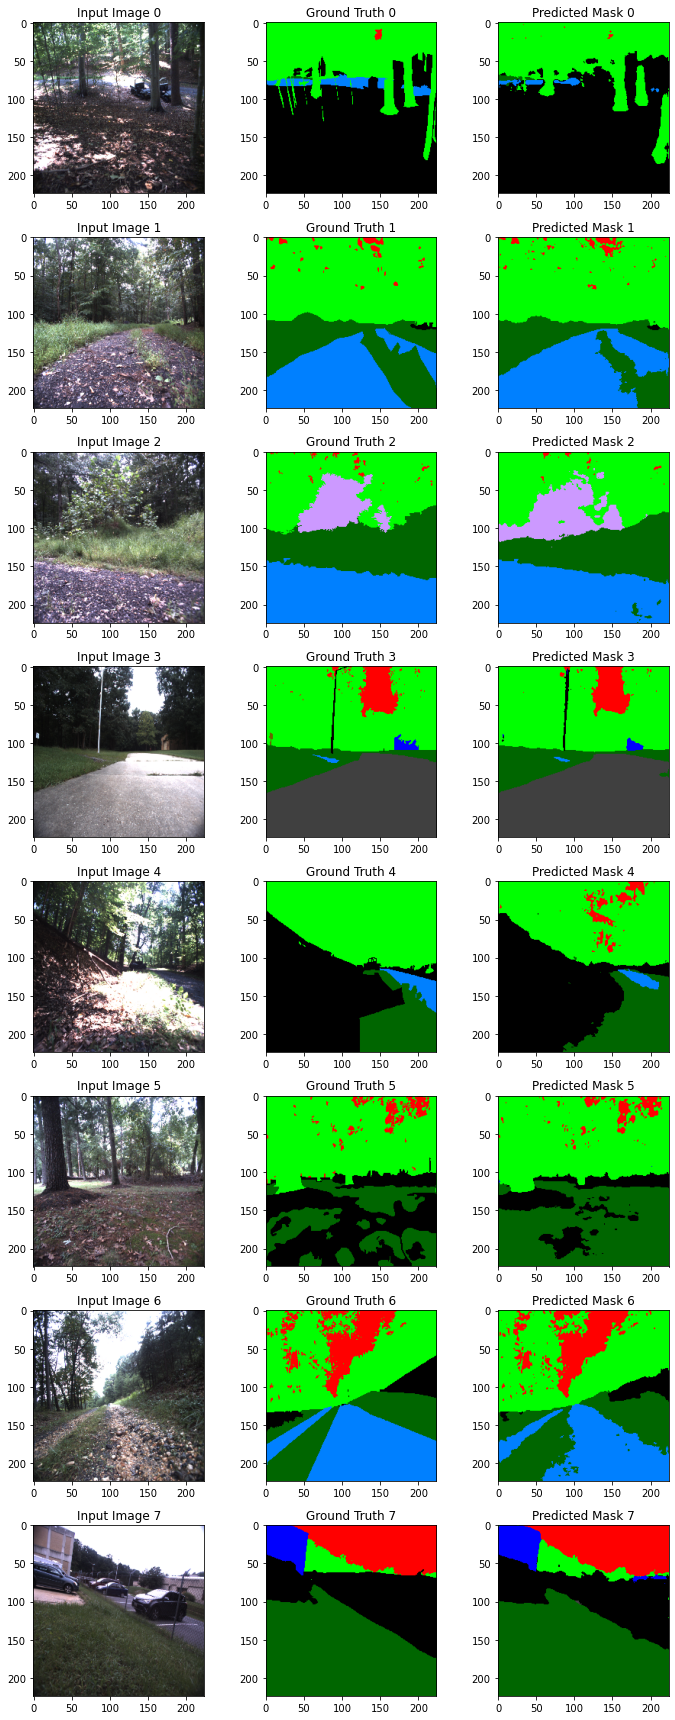

In [16]:
# Get one batch from test dataset
for test_img, test_mask in test_dataset.take(1):
    pred_mask = best_model.predict(test_img)
    pred_mask = np.argmax(pred_mask, axis=-1)  # Convert softmax to class labels

    print("Unique values in predicted mask:", np.unique(pred_mask))
    print("Unique values in test mask:", np.unique(test_mask))
    break  # Process only one batch

# Convert to numpy array for easy indexing
color_array = np.array([color_map[key] for key in sorted(color_map.keys())], dtype=np.uint8)

# Function to apply color map to label mask
def apply_color_map(label_mask):
    """Convert label mask (H, W) to a color image (H, W, 3)."""
    return color_array[label_mask]

# Ensure predicted mask only contains valid labels
valid_labels = np.array(list(color_map.keys()))
pred_mask = np.where(np.isin(pred_mask, valid_labels), pred_mask, 0)  # Map invalid classes to 0 (void)

# Convert grayscale masks to color
test_mask_color = np.array([apply_color_map(mask) for mask in test_mask])
pred_mask_color = np.array([apply_color_map(mask) for mask in pred_mask])

# Number of images in the batch
batch_size = test_img.shape[0]

# Display results for entire batch
fig, axes = plt.subplots(batch_size, 3, figsize=(10, batch_size * 3))

for i in range(batch_size):
    axes[i, 0].imshow(test_img[i])
    axes[i, 0].set_title(f"Input Image {i}")
    
    axes[i, 1].imshow(test_mask_color[i])
    axes[i, 1].set_title(f"Ground Truth {i}")
    
    axes[i, 2].imshow(pred_mask_color[i])
    axes[i, 2].set_title(f"Predicted Mask {i}")

plt.tight_layout()
plt.show()